The following is the code to analyze the three pattern experiment. In this experiments, after receiving a few 10 min sessions in closed-loop with the bar, the flies were exposed to a session in which there were 3 types of stimulus:
-a 2 px blue bar in closed-loop
-panels off
-a 1 px horizontal bar in the midline of the arena with lower contrast to match the intensity of the 2 px bar
The stimuli changed every 60 sec in a fixed way.

In [1]:
#Import all the modules we will be using

import os
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from scipy.stats import circstd, pearsonr
from scipy.signal import medfilt
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from astropy.stats import circcorrcoef
from scipy.signal import find_peaks, peak_widths, peak_prominences

In [2]:
#Load data for single analyses
mainDir = os.getcwd()[:-7]

In [12]:
folders = os.listdir(mainDir + '\data\\three_patterns')  #get the list of folders in it
flyNum = len(folders) #determine fly number

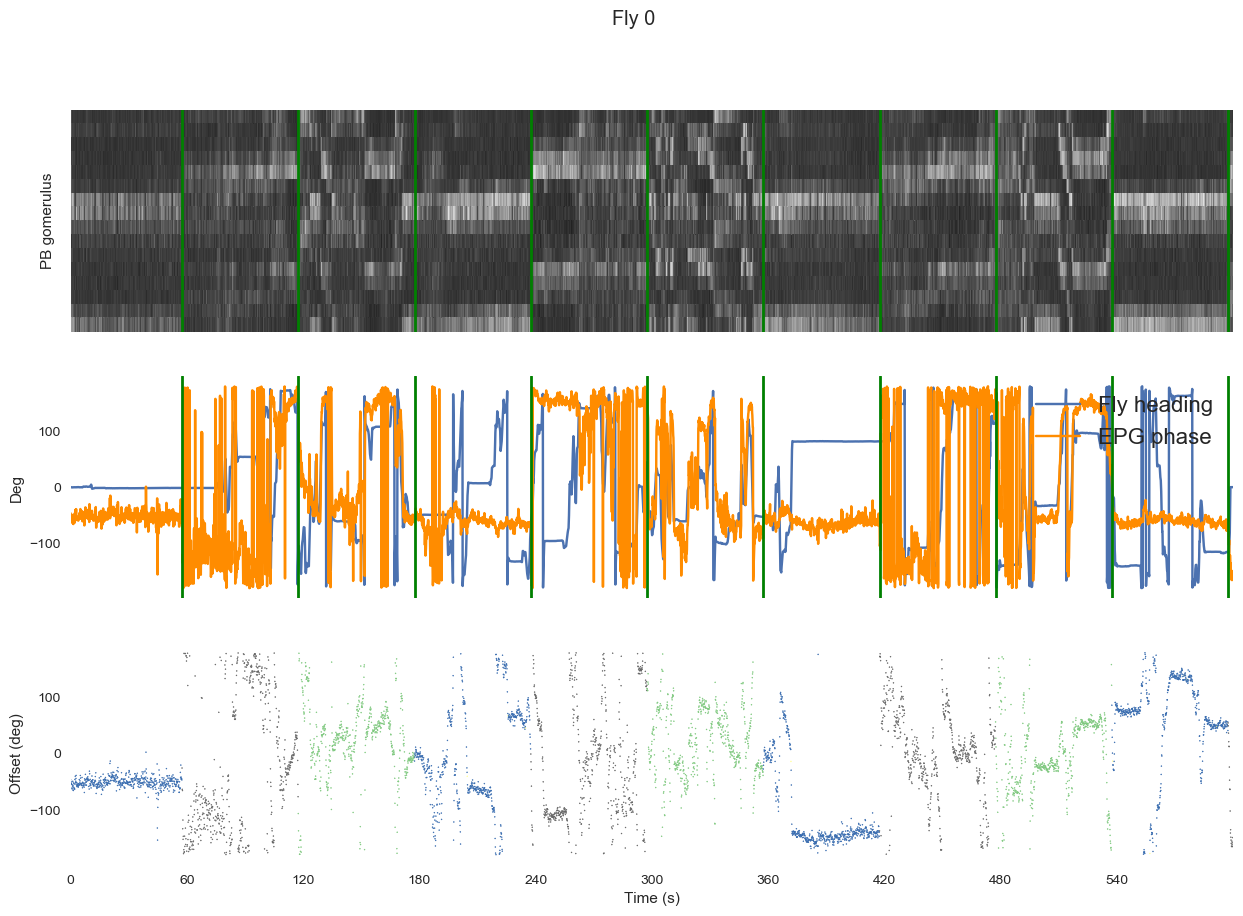

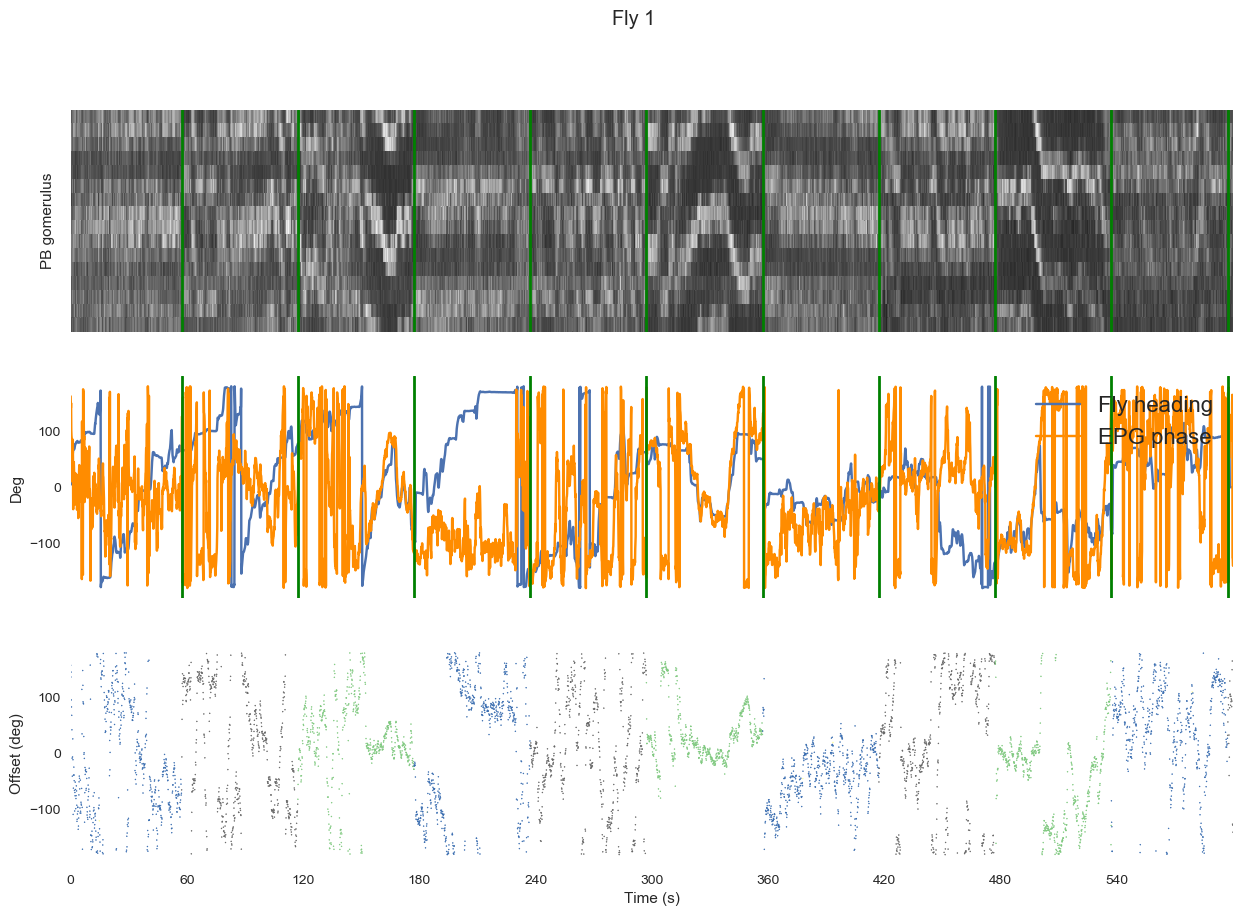

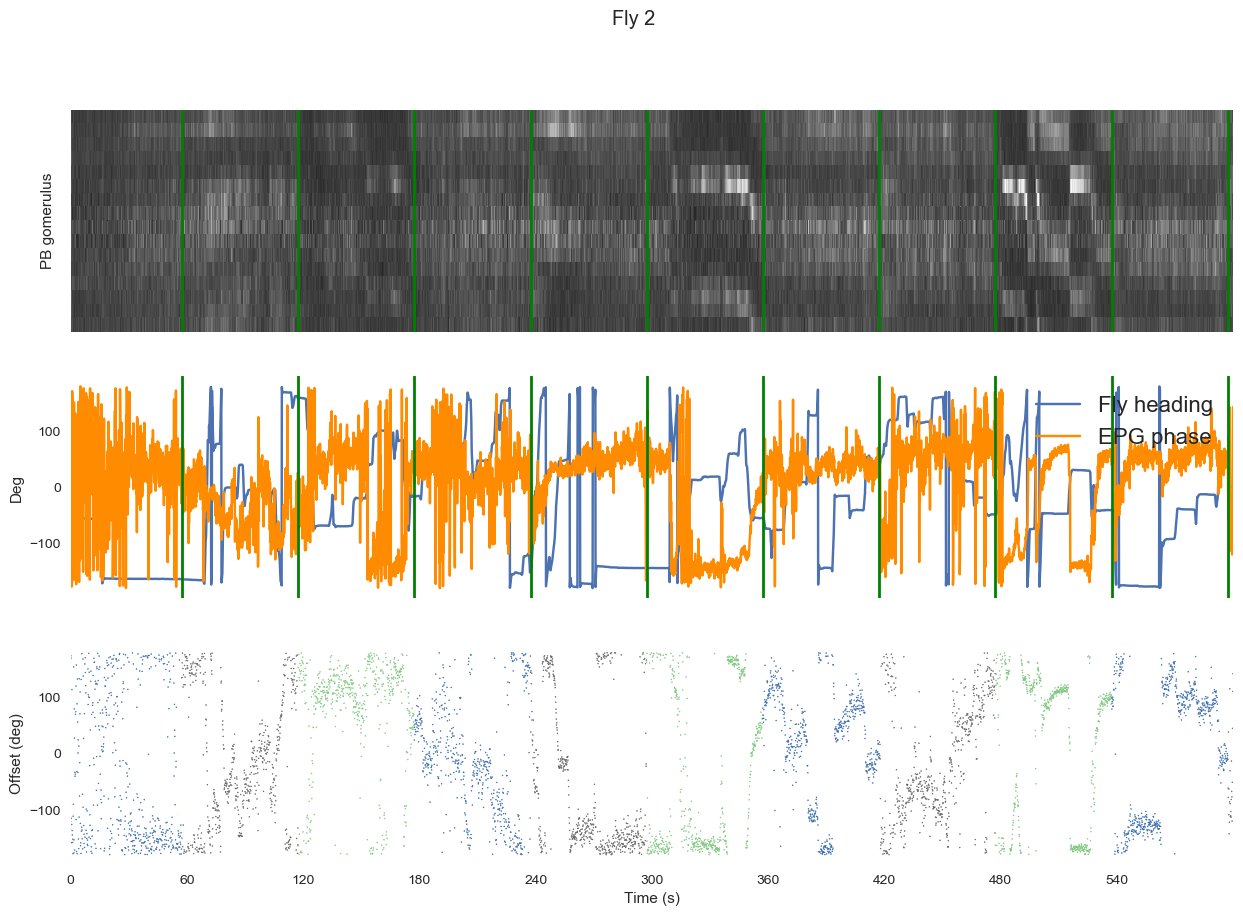

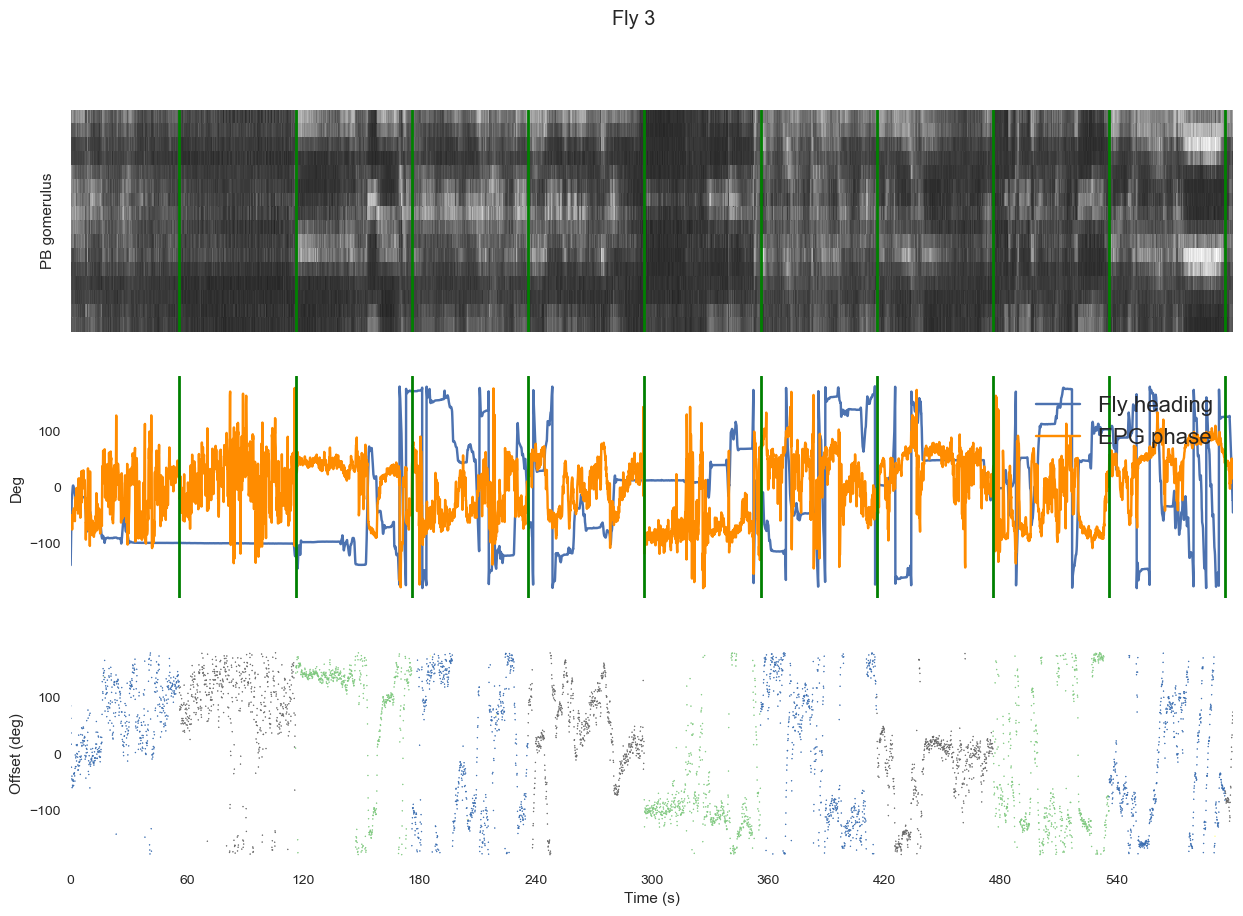

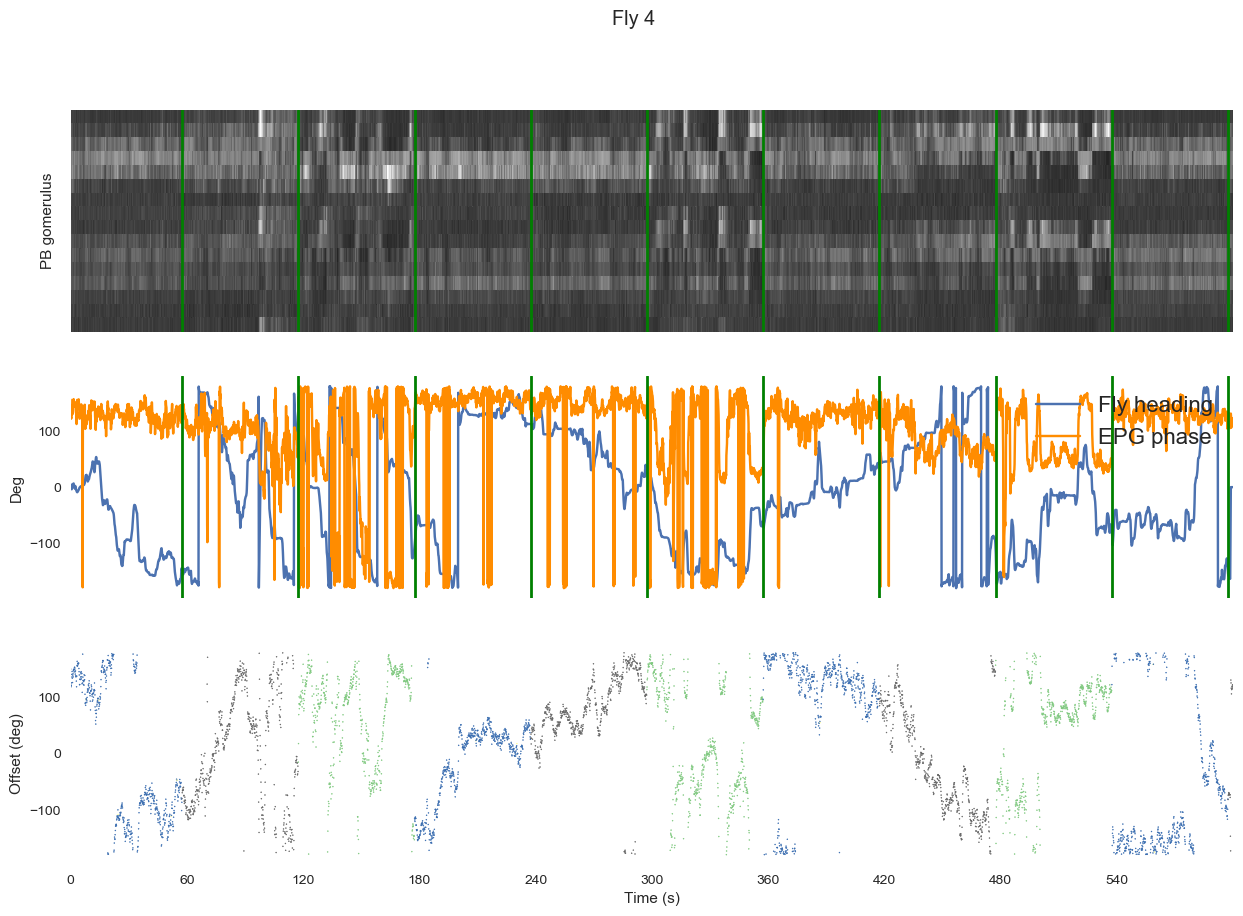

In [20]:
#For each fly, plot the heatmap for the neural data, the fly heading and EPG phase, and the offset

groupData = {}
plt.rcParams['image.cmap'] = 'Accent'


for fly in range(flyNum): #for each of the folders
    os.chdir(mainDir + '\data\\three_patterns\\' + folders[fly]) #move inside of the folder, inside the dark trial folder
    file = os.listdir() #get the file names
    data = sio.loadmat(file[0], struct_as_record=False) #load the file. This is loaded as a dictionnary, where the data is stored in a dictionnary key called 'data' (you can see this bu running dict.keys())   
    flyData = data['data'] #store only the data from that dictionnary object into a new object called flyData. This is now a numpy.ndarray 
    
    allFrames = np.linspace(1,5509,5509)
    changeStim = allFrames[abs(np.ediff1d(flyData[0,0].fr_y_ds))>1]
    #plot heatmap of neural activity
    dff_matrix = flyData[0,0].dff_matrix
    my_cmap = sns.dark_palette("white", as_cmap=True)
    fig,(ax1, ax2, ax3) = plt.subplots(3,1, figsize = (15, 10), dpi=100)
    fig.suptitle('Fly ' + str(fly))
    g = sns.heatmap(dff_matrix,cmap=my_cmap,ax=ax1, cbar=False)
    g.set(xticklabels=[])
    g.set(yticklabels=[])
    g.set_ylabel('PB gomerulus')
    plt.setp(ax1.get_xticklabels(), visible=False)
    for i in range(np.size(changeStim)):
        ax1.axvline(x=changeStim[i], color='green', lw = 2)

    ax2 = plt.subplot(312, sharex=ax1)
    ax2.plot(np.rad2deg(flyData[0,0].flyPosRad))  
    ax2.plot(np.transpose(np.rad2deg(flyData[0,0].phase)),color='darkorange')   
    ax2.set(xticklabels=[])
    ax2.set(ylabel='Deg')
    ax2.set_facecolor('white')
    plt.setp(ax2.get_xticklabels(), visible=False)
    ax2.legend(('Fly heading', 'EPG phase'),loc='upper right', prop={'size': 16})
    for i in range(np.size(changeStim)):
        ax2.axvline(x=changeStim[i], color='green', lw = 2)
      
    ax3 = plt.subplot(313, sharex = ax1)
    offset =  np.transpose((np.rad2deg(flyData[0,0].offset3))) 
    time = flyData[0,0].time
    #ax3.plot(offset, color = 'black', linestyle=':') 
    ax3.scatter(range(len(offset)), offset,[],flyData[0,0].fr_y_ds)
    ax3.set_facecolor('white')
    plt.ylabel('Offset (deg)')
    plt.xlabel('Time (s)')
    x_locations = np.arange(0, len(flyData[0,0].time), 551)
    ax3.set_xticks(x_locations)
    ax3.set_xticklabels(('0','60','120','180','240','300','360','420','480','540','600')) #get a better handle on time
    
    #save data in group data structure
    groupData[fly] = flyData #I'm missing the necessary field names
    
    plt.savefig(mainDir + "\plots\IndividualPlots3PatternFly"  + str(fly) + ".png", dpi=150)

In [6]:
# Load group data

groupData = sio.loadmat(mainDir + '\data\\allData.mat', struct_as_record=True)
flyGroupData = groupData['Data']

C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In

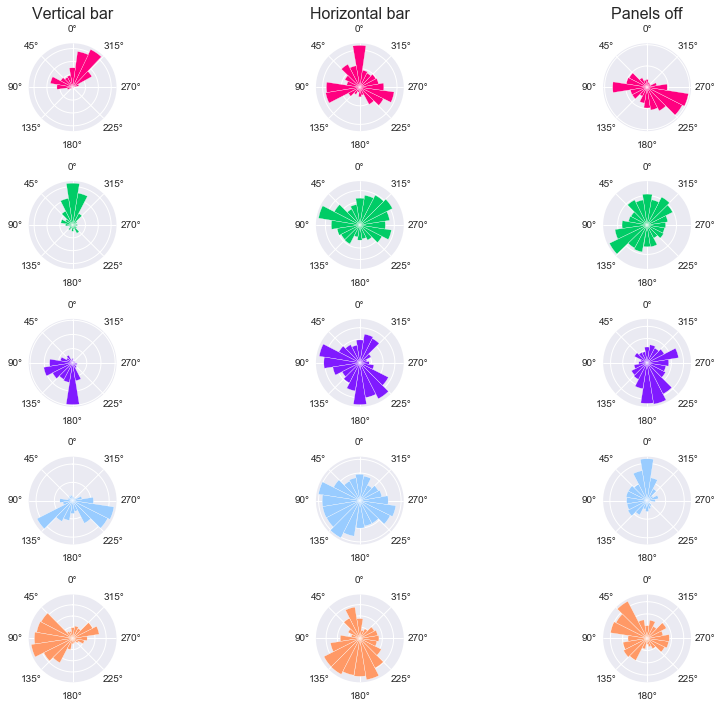

In [7]:
# Plot the offset distribution for each fly

# Set color palette for flies
palette = [(1,0,0.5),(0,0.8,0.4),(0.5,0.1,1),(0.6,0.8,1),(1,0.6,0.4)]
    
plt.style.use('seaborn')

bins_number = 20
width = 2 * np.pi / bins_number

fig = plt.figure()

for fly in range(flyNum):
    angles1 = flyGroupData[0,fly]['offset'][0,flyGroupData[0,fly]['singleBar']-1]   
    angles2 = flyGroupData[0,fly]['offset'][0,flyGroupData[0,fly]['ambiguous']-1]  
    angles3 = flyGroupData[0,fly]['offset'][0,flyGroupData[0,fly]['darkness']-1]  
    
    ax = fig.add_subplot(5, 3, fly+1+2*fly)
    polar_ax = fig.add_subplot(5, 3, fly+1+2*fly, projection="polar")
    # bin data for our polar histogram
    count, bin = np.histogram(angles1, bins=bins_number)
    # Plot polar histogram
    polar_ax.bar(bin[:-1], count, align='center', width=width, color = palette[fly])
    polar_ax.set_yticklabels([])
    polar_ax.set_theta_zero_location("N")

    ax2 = fig.add_subplot(5, 3, fly+2+2*fly)
    polar_ax2 = fig.add_subplot(5, 3, fly+2+2*fly, projection="polar")
    count2, bin = np.histogram(angles2, bins=bins_number)
    polar_ax2.bar(bin[:-1], count2, align='center', width=width, color = palette[fly])
    polar_ax2.set_yticklabels([])
    polar_ax2.set_theta_zero_location("N")
    
    ax3 = fig.add_subplot(5, 3, fly+3+2*fly)
    polar_ax3 = fig.add_subplot(5, 3, fly+3+2*fly, projection="polar")
    count3, bin = np.histogram(angles3, bins=bins_number)
    polar_ax3.bar(bin[:-1], count3, align='center', width=width, color = palette[fly])
    polar_ax3.set_yticklabels([])
    polar_ax3.set_theta_zero_location("N")
    
    if fly == 0:
        polar_ax.set_title('Vertical bar', pad=20, fontsize=16)    
        polar_ax2.set_title('Horizontal bar', pad=20, fontsize=16)
        polar_ax3.set_title('Panels off', pad=20, fontsize=16)
    
    fig.tight_layout()
    plt.gcf().set_size_inches(15, 10)
    plt.savefig(mainDir + "\\plots\PolarHistOffset3Pattern.png", dpi=150)

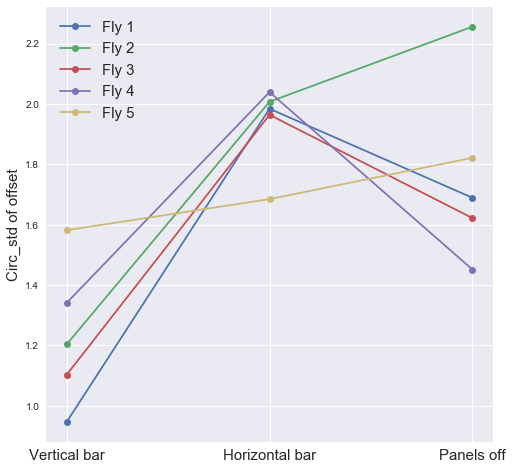

In [61]:
# Get and plot offset variation in each case
# We are going to quantify the trends observed in the previous plot by calculating the circular standard deviation per state for each fly.

offset_variation = np.empty([flyNum, 3])

for fly in range(flyNum):
    offset_variation[fly,0] = circstd(flyGroupData[0,fly]['offset'][0,flyGroupData[0,fly]['singleBar']-1])
    offset_variation[fly,1] = circstd(flyGroupData[0,fly]['offset'][0,flyGroupData[0,fly]['ambiguous']-1])
    offset_variation[fly,2] = circstd(flyGroupData[0,fly]['offset'][0,flyGroupData[0,fly]['darkness']-1] )
    
offset_variation = np.transpose(offset_variation)

plt.plot(offset_variation,marker="o")
plt.ylabel('Circ_std of offset',fontsize=15)
#plt.title('Offset variation across states',fontsize=20)
plt.xticks([0,1,2], ['Vertical bar','Horizontal bar','Panels off'],fontsize=15)
plt.legend(['Fly 1', 'Fly 2', 'Fly 3','Fly 4','Fly 5'],fontsize=15)
plt.gcf().set_size_inches(8, 8)
plt.savefig(mainDir + "\\plots\OffsetVariation3Pattern.png", dpi=150)

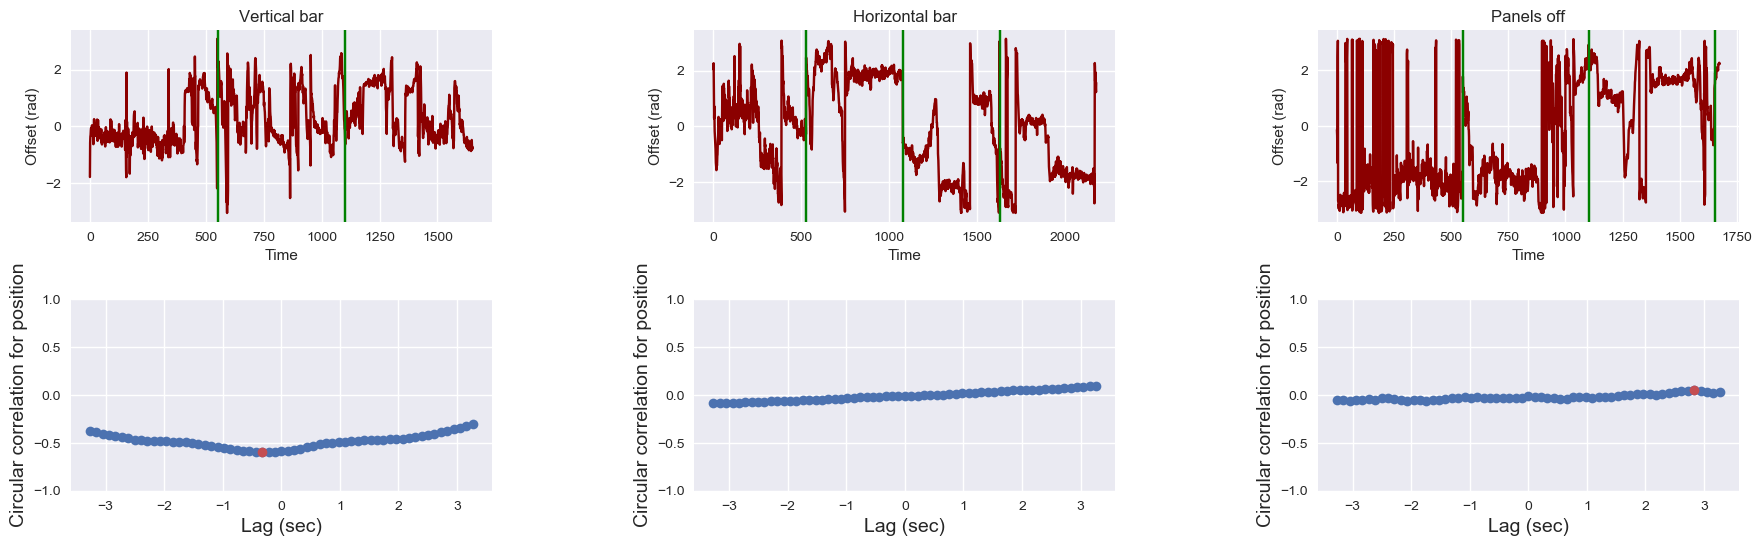

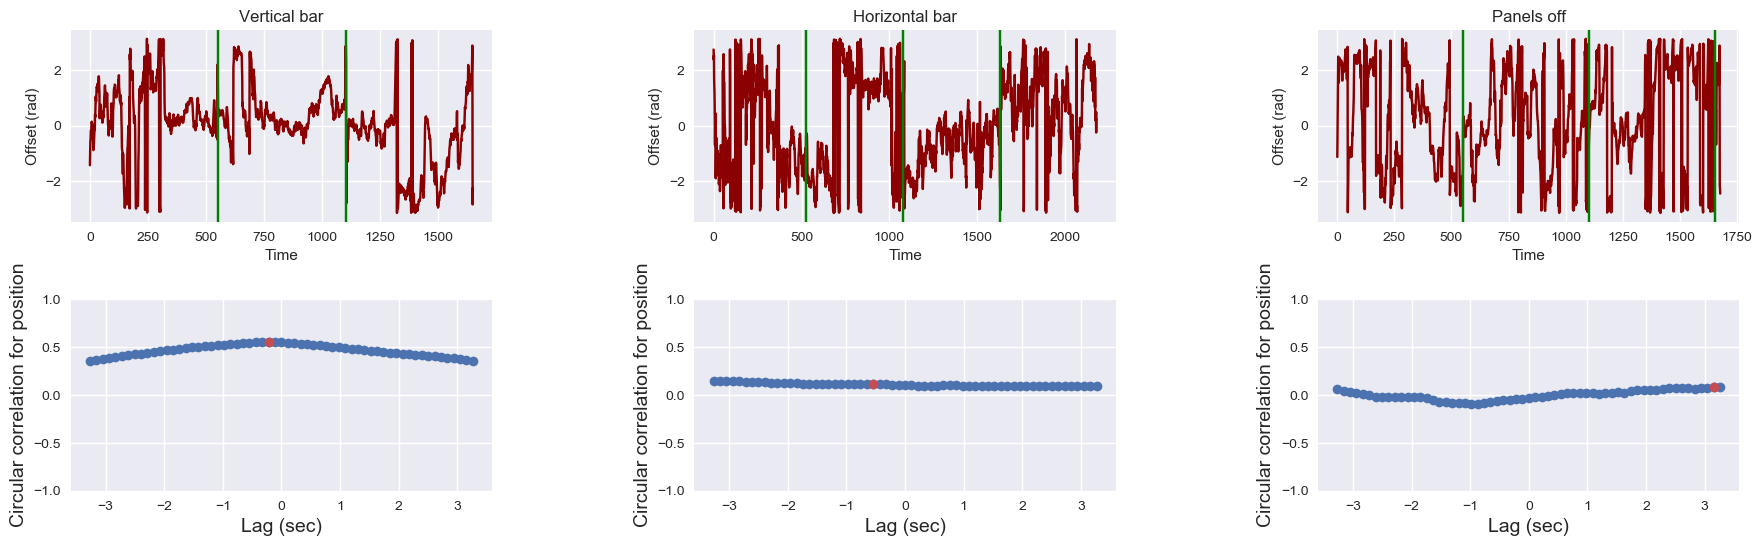

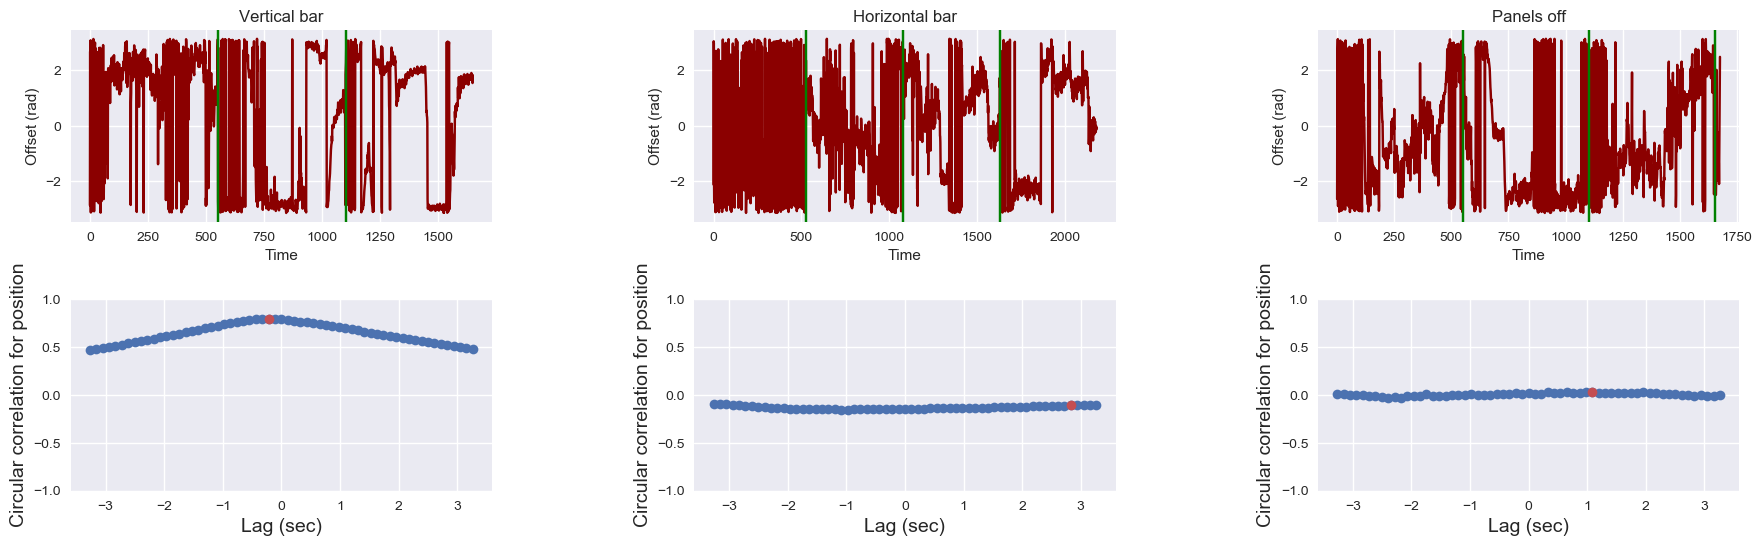

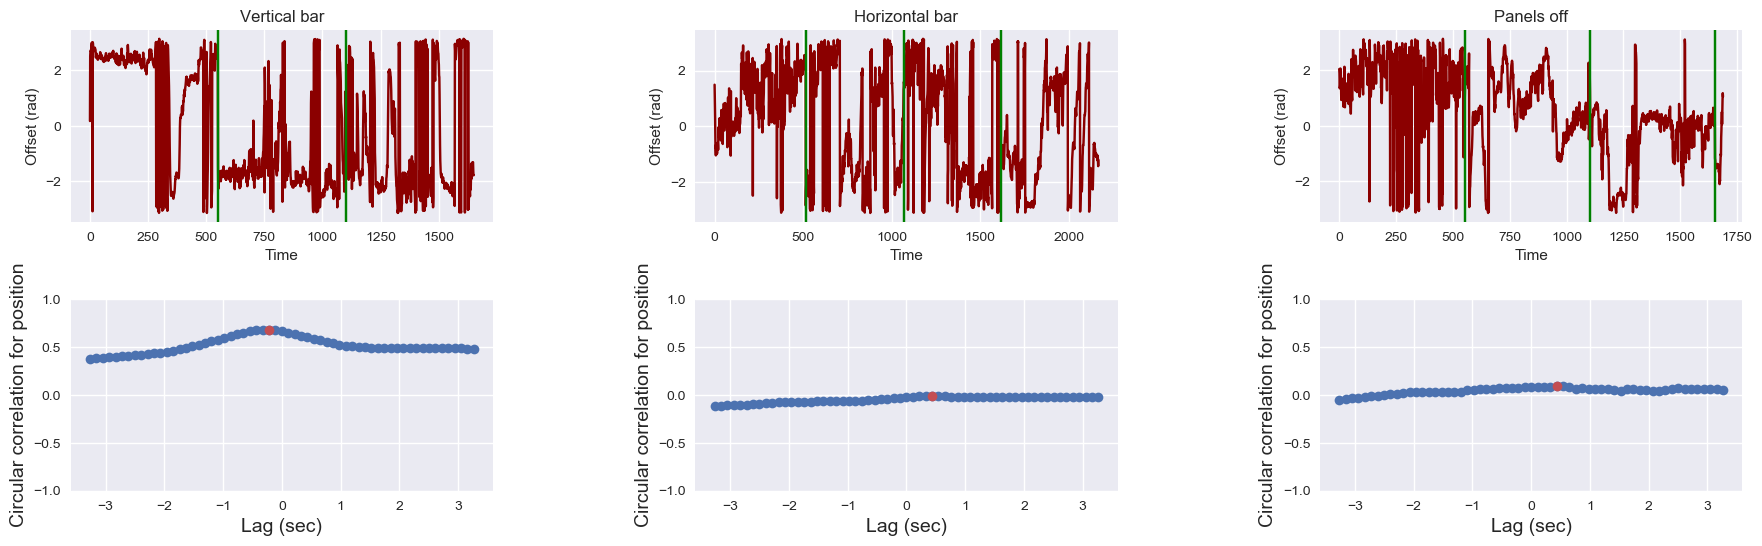

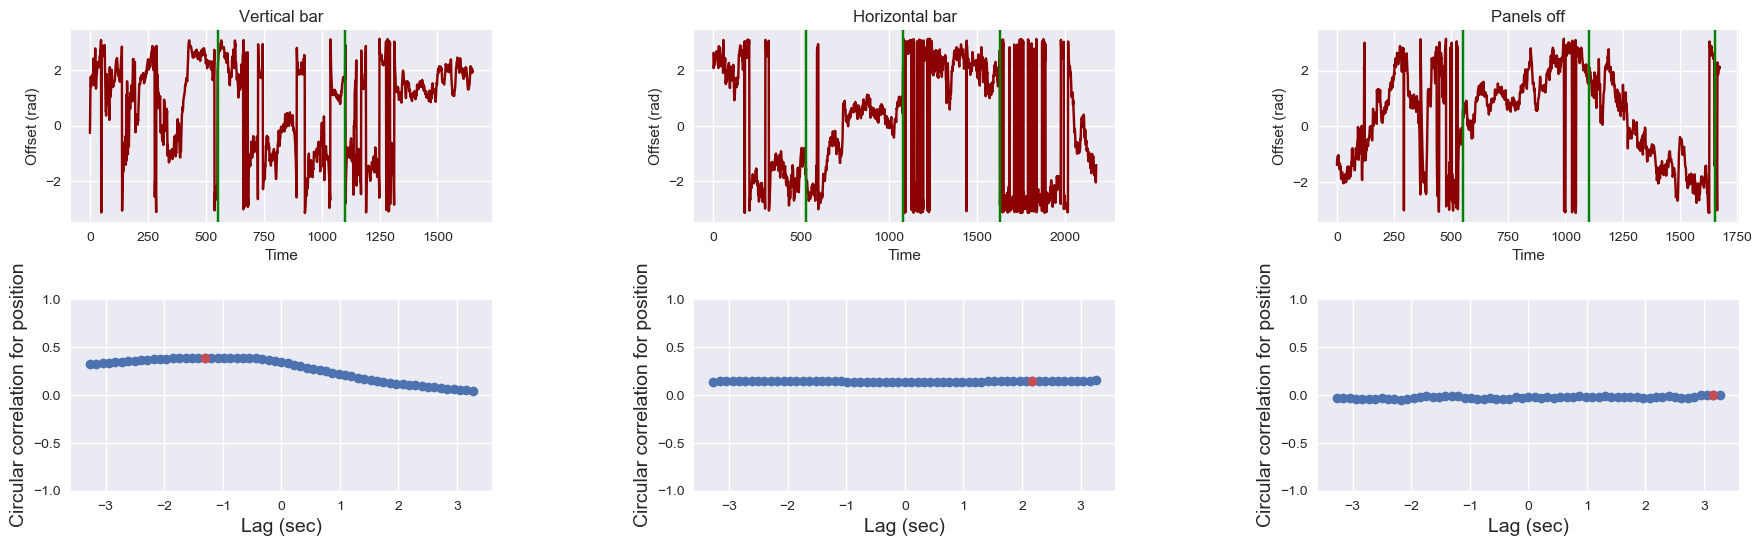

In [8]:
# Let's look at fly behavior and EPG phase correlations, using the method from Green et al., 2017

DataCorr = np.zeros((flyNum,3))

for fly in range(flyNum):
    fig, axs = plt.subplots(2,3, figsize = (15, 10), dpi=100)
    
    offset = flyGroupData[0,fly]['offset'][0,flyGroupData[0,fly]['singleBar']-1]
    axs[0,0].plot(offset,color='darkred')
    barChange = [np.ediff1d(flyGroupData[0,fly]['singleBar'])>100]
    barChange = np.append(False,barChange)
    barFrames = np.linspace(1,len(barChange),len(barChange))
    barChangeFrames = barFrames[barChange]
    for change in range(len(barChangeFrames)):
        axs[0,0].axvline(x=barChangeFrames[change],color='green')
    axs[0,0].set(ylabel='Offset (rad)')
    axs[0,0].set(xlabel='Time')    
          
    actualHeading1 = np.unwrap(-flyGroupData[0,fly]['flyPosRad'][flyGroupData[0,fly]['singleBar']-1])
    decodedHeading1 = np.unwrap(flyGroupData[0,fly]['phase_value'][0,flyGroupData[0,fly]['singleBar']-1])    
    #try different lags
    #Initialize a vector of all the possible lags
    lags = np.arange(-30, 31, 1)
    timeLag = lags*(600/5510) #change from ds frames to sec
    circCoef1 = np.zeros((len(lags),1))
    #run a loop for every element in the lags vector
    for lag in lags:
        #circularly shift the decoded heading by that lag
        shiftedDecodHeading1 = np.roll(np.squeeze(decodedHeading1),lags[lag])
        #compute the circular correlation and save
        circCoef1[lag] = circcorrcoef(np.squeeze(actualHeading1),shiftedDecodHeading1)   
        
    #find the peaks
    peaks, _ = find_peaks(circCoef1[:,0])
    #retain the taller peak
    peakValues = circCoef1[peaks]
    MinToMaxOrder = np.argsort(peakValues, axis=0)
    MaxToMinOrder = np.flip(MinToMaxOrder)
    Peaks = peaks[MaxToMinOrder[0:1]]
    #add to plot
    axs[1,0].plot(timeLag,circCoef1,marker='o')
    if len(Peaks) != 0:
        axs[1,0].plot(timeLag[Peaks[0,0]], circCoef1[Peaks[0,0],0],'ro')
    axs[1,0].set_ylabel('Circular correlation for position', fontsize=14)
    axs[1,0].set_xlabel('Lag (sec)', fontsize=14)
    axs[1,0].set_ylim(-1,1)
    if len(Peaks) == 0:
        DataCorr[fly,0] = 0
    else:
        DataCorr[fly,0] = circCoef1[Peaks[0,0],0]
    
    
    offset = flyGroupData[0,fly]['offset'][0,flyGroupData[0,fly]['ambiguous']-1]
    axs[0,1].plot(offset,color='darkred')
    ambiguousChange = [np.ediff1d(flyGroupData[0,fly]['ambiguous'])>100]
    ambiguousChange = np.append(False,ambiguousChange)
    ambiguousFrames = np.linspace(1,len(ambiguousChange),len(ambiguousChange))
    ambiguousChangeFrames = ambiguousFrames[ambiguousChange]
    for change in range(len(ambiguousChangeFrames)):
        axs[0,1].axvline(x=ambiguousChangeFrames[change],color='green')
    axs[0,1].set(ylabel='Offset (rad)')
    axs[0,1].set(xlabel='Time')    
          
    actualHeading2 = np.unwrap(-flyGroupData[0,fly]['flyPosRad'][flyGroupData[0,fly]['ambiguous']-1])
    decodedHeading2 = np.unwrap(flyGroupData[0,fly]['phase_value'][0,flyGroupData[0,fly]['ambiguous']-1])    
    #try different lags
    #Initialize a vector of all the possible lags
    lags = np.arange(-30, 31, 1)
    timeLag = lags*(600/5510) #change from ds frames to sec
    circCoef2 = np.zeros((len(lags),1))
    #run a loop for every element in the lags vector
    for lag in lags:
        #circularly shift the decoded heading by that lag
        shiftedDecodHeading2 = np.roll(np.squeeze(decodedHeading2),lags[lag])
        #compute the circular correlation and save
        circCoef2[lag] = circcorrcoef(np.squeeze(actualHeading2),shiftedDecodHeading2)   
        
    #find the peaks
    peaks, _ = find_peaks(circCoef2[:,0])
    #retain the taller peak
    peakValues = circCoef2[peaks]
    MinToMaxOrder = np.argsort(peakValues, axis=0)
    MaxToMinOrder = np.flip(MinToMaxOrder)
    Peaks = peaks[MaxToMinOrder[0:1]]
    #add to plot
    axs[1,1].plot(timeLag,circCoef2,marker='o')
    if len(Peaks) != 0:
        axs[1,1].plot(timeLag[Peaks[0,0]], circCoef2[Peaks[0,0],0],'ro')
    axs[1,1].set_ylabel('Circular correlation for position', fontsize=14)
    axs[1,1].set_xlabel('Lag (sec)', fontsize=14)
    axs[1,1].set_ylim(-1,1)
    if len(Peaks) == 0:
        DataCorr[fly,1] = 0
    else:
        DataCorr[fly,1] = circCoef2[Peaks[0,0],0]
   
    
    offset = flyGroupData[0,fly]['offset'][0,flyGroupData[0,fly]['darkness']-1]
    axs[0,2].plot(offset,color='darkred')
    darknessChange = [np.ediff1d(flyGroupData[0,fly]['darkness'])>100]
    darknessChange = np.append(False,darknessChange)
    darknessFrames = np.linspace(1,len(darknessChange),len(darknessChange))
    darknessChangeFrames = darknessFrames[darknessChange]
    for change in range(len(darknessChangeFrames)):
        axs[0,2].axvline(x=darknessChangeFrames[change],color='green')
    axs[0,2].set(ylabel='Offset (rad)')
    axs[0,2].set(xlabel='Time')    
          
    actualHeading3 = np.unwrap(np.rad2deg(-flyGroupData[0,fly]['flyPosRad'][flyGroupData[0,fly]['darkness']-1]))
    decodedHeading3 = np.unwrap(flyGroupData[0,fly]['phase_value'][0,flyGroupData[0,fly]['darkness']-1])    
    #try different lags
    #Initialize a vector of all the possible lags
    lags = np.arange(-30, 31, 1)
    timeLag = lags*(600/5510) #change from ds frames to sec
    circCoef3 = np.zeros((len(lags),1))
    #run a loop for every element in the lags vector
    for lag in lags:
        #circularly shift the decoded heading by that lag
        shiftedDecodHeading3 = np.roll(np.squeeze(decodedHeading3),lags[lag])
        #compute the circular correlation and save
        circCoef3[lag] = circcorrcoef(np.squeeze(actualHeading3),shiftedDecodHeading3)   
        
    #find the peaks
    peaks, _ = find_peaks(circCoef3[:,0])
    #retain the taller peak
    peakValues = circCoef3[peaks]
    MinToMaxOrder = np.argsort(peakValues, axis=0)
    MaxToMinOrder = np.flip(MinToMaxOrder)
    Peaks = peaks[MaxToMinOrder[0:1]]
    #add to plot
    axs[1,2].plot(timeLag,circCoef3,marker='o')
    if len(Peaks) != 0:
        axs[1,2].plot(timeLag[Peaks[0,0]], circCoef3[Peaks[0,0],0],'ro')
    axs[1,2].set_ylabel('Circular correlation for position', fontsize=14)
    axs[1,2].set_xlabel('Lag (sec)', fontsize=14)
    axs[1,2].set_ylim(-1,1)
    if len(Peaks) == 0:
        DataCorr[fly,2] = 0
    else:
        DataCorr[fly,2] = circCoef3[Peaks[0,0],0]
        
    axs[0,0].set(title='Vertical bar')
    axs[0,1].set(title='Horizontal bar')
    axs[0,2].set(title='Panels off')
    
    fig.tight_layout(pad=5.0)
    plt.gcf().set_size_inches(20, 6)
    plt.savefig(mainDir + "\\plots\individualCorr3patternFly" + str(fly) + ".png", dpi=150)
    
    #I get a negative correlation for the first fly, which seems really odd...

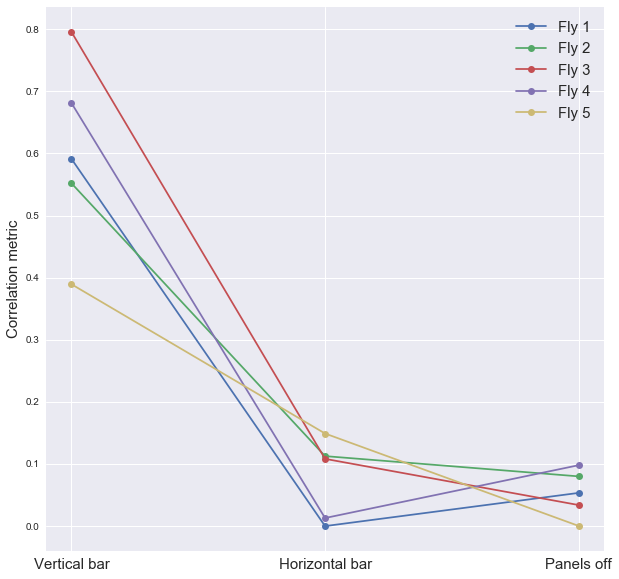

In [9]:
#Let's plot the higher correlation per condition

plt.plot(abs(np.transpose(DataCorr)),marker="o")
plt.ylabel('Correlation metric',fontsize=15)
plt.xticks([0,1,2], ['Vertical bar','Horizontal bar','Panels off'],fontsize=15)
plt.legend(['Fly 1', 'Fly 2', 'Fly 3','Fly 4','Fly 5'],fontsize=15)
plt.gcf().set_size_inches(10, 10)
plt.savefig(mainDir + "\\plots\\allCorrGreen3Pattern.png", dpi=150)


In [10]:
#Let's analyze bump magnitude and bump width at half max importing the von Mises fit from MATLAB

os.chdir(mainDir + '\data\\') #move inside of the folder, inside the dark trial folder
fitdata = sio.loadmat('fitdata.mat', struct_as_record=False) #load the file. This is loaded as a dictionnary, where the data is stored in a dictionnary key called 'data' (you can see this bu running dict.keys())   
fit_bump_mag = fitdata['bump_mag'] 
fit_half_width = fitdata['half_width'] 

In [11]:
#Initialize a data frame and store the bump data

state = []
frames = np.shape(flyGroupData[0,0]['dff_matrix'])[1]

for fly in range(flyNum):
    for frame in range(frames):
        if any(flyGroupData[0,fly]['singleBar']-1 == frame):
            state.append(1)
        elif any(flyGroupData[0,fly]['ambiguous']-1 == frame):
            state.append(2)
        else:
            state.append(3)
                
flyID = np.repeat(np.array(range(flyNum))+1,frames)
time = [flyData[0,0].time,flyData[0,0].time,flyData[0,0].time,flyData[0,0].time,flyData[0,0].time]
time = np.reshape(time,frames*5)

# Combine all the data in a dataframe
bumpdata = {'Fly ID': flyID, 'State': state, 'Time': time}
bumpDF = pd.DataFrame(bumpdata)

# Add to data frame
bumpDF['bumpMagFit'] = np.transpose(fit_bump_mag)
bumpDF['bumpHWFit'] = np.transpose(fit_half_width)

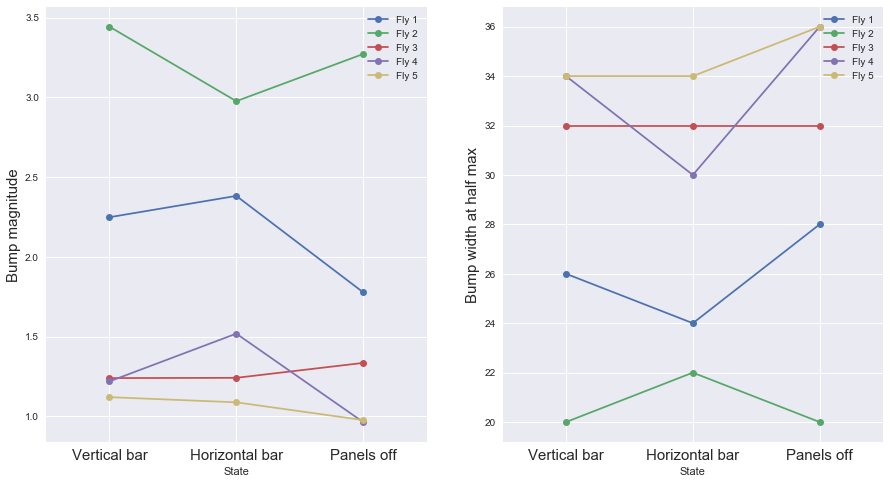

In [123]:
#Plot the median data

plt.style.use('seaborn')

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

bumpDF.groupby(['State','Fly ID'])[['bumpMagFit']].median().unstack().plot(marker="o", ax=ax1)
ax1.set_ylabel('Bump magnitude',fontsize=15)
ax1.set_xticks([1,2,3])
ax1.set_xticklabels(['Vertical bar','Horizontal bar','Panels off'],fontsize=15)
ax1.legend(['Fly 1', 'Fly 2', 'Fly 3', 'Fly 4', 'Fly 5'])
ax1.set_xlim(0.5,3.5)

bumpDF.groupby(['State','Fly ID'])[['bumpHWFit']].median().unstack().plot(marker="o", ax=ax2)
ax2.set_ylabel('Bump width at half max', fontsize=15)
ax2.set_xticks([1,2,3])
ax2.set_xticklabels(['Vertical bar','Horizontal bar','Panels off'],fontsize=15)
ax2.legend(['Fly 1', 'Fly 2', 'Fly 3', 'Fly 4', 'Fly 5'])
ax2.set_xlim(0.5,3.5)

plt.gcf().set_size_inches(15, 8)
plt.savefig(mainDir + "\plots\medianFitValuesMatlab3pattern.png", dpi=150)

bumpMagFit = bumpDF['bumpMagFit']

In [125]:
#Bump magnitude as max-min (in case the fit isn't good). 

def stat_range(x):
    return max(x) - min(x)

#for each fly, calculate range
leftPB = [0,1,2,3,4,5,6,7]
rightPB = [9,10,11,12,13,14,15,8]
newData = []
smoothedData = []

for fly in range(flyNum):
        #average the data from the two PB halves
        combined_dff = (flyGroupData[0,fly]['dff_matrix'][leftPB,:] + flyGroupData[0,fly]['dff_matrix'][rightPB,:] )/2
        #newData.append(np.apply_along_axis(stat_range, 0, flyGroupData[0,fly]['dff_matrix']))
        newData.append(np.apply_along_axis(stat_range, 0, combined_dff))        
        smoothedData.append(gaussian_filter(newData[fly], sigma=5)) #change sigma for the smoothing window
                
bumpData = np.reshape(np.array(newData),flyNum*len(newData[0]))
smoothedBumpData = np.reshape(np.array(smoothedData),flyNum*len(smoothedData[0]))

bumpDF['BumpMagMinMax'] = bumpData
bumpDF['SmoothedBumpMagMinMax'] = smoothedBumpData


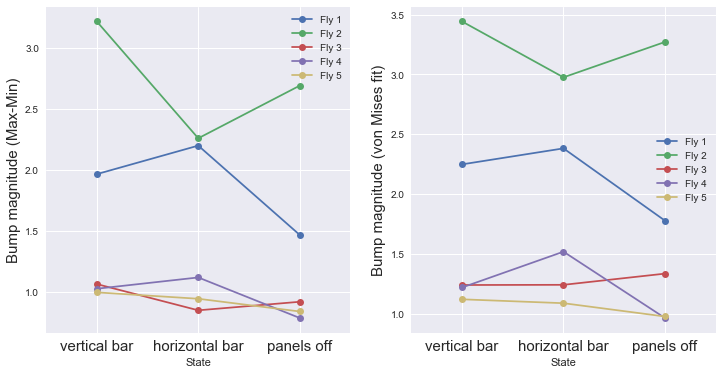

In [145]:
# Calculate and plot median bump magnitude for each state, and plot them alongside the von Mises fit values, to see how they compare

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
bumpDF.groupby(['State','Fly ID'])[['BumpMagMinMax']].median().unstack().plot(marker="o",ax=ax1)
ax1.set_ylabel('Bump magnitude (Max-Min)',fontsize=15)
ax1.set_xticks([1,2,3])
ax1.set_xticklabels(['vertical bar','horizontal bar','panels off'],fontsize=15)
ax1.legend(['Fly 1', 'Fly 2', 'Fly 3', 'Fly 4', 'Fly 5'])
ax1.set_xlim(0.5,3.5)

bumpDF.groupby(['State','Fly ID'])[['bumpMagFit']].median().unstack().plot(marker="o",ax=ax2)
ax2.set_ylabel('Bump magnitude (von Mises fit)',fontsize=15)
ax2.set_xticks([1,2,3])
ax2.set_xticklabels(['vertical bar','horizontal bar','panels off'],fontsize=15)
ax2.legend(['Fly 1', 'Fly 2', 'Fly 3', 'Fly 4', 'Fly 5'])
ax2.set_xlim(0.5,3.5)


plt.gcf().set_size_inches(12, 6)
plt.savefig(mainDir + "\plots\BumpMagComparison.png", dpi=150)

In [274]:
# We are going to now store the animal's angular speed data

flyAngSpeed = []

for fly in range(flyNum):
        flyAngSpeed.extend(abs(flyGroupData[0,fly]['ang_vel'][0,flyGroupData[0,fly]['singleBar']-1]))
        flyAngSpeed.extend(abs(flyGroupData[0,fly]['ang_vel'][0,flyGroupData[0,fly]['ambiguous']-1]))
        flyAngSpeed.extend(abs(flyGroupData[0,fly]['ang_vel'][0,flyGroupData[0,fly]['darkness']-1]))

flyAngSpeed.append(flyAngSpeed[-1])
bumpDF['flyAngSpeed'] = flyAngSpeed
angSpeed = bumpDF['flyAngSpeed']

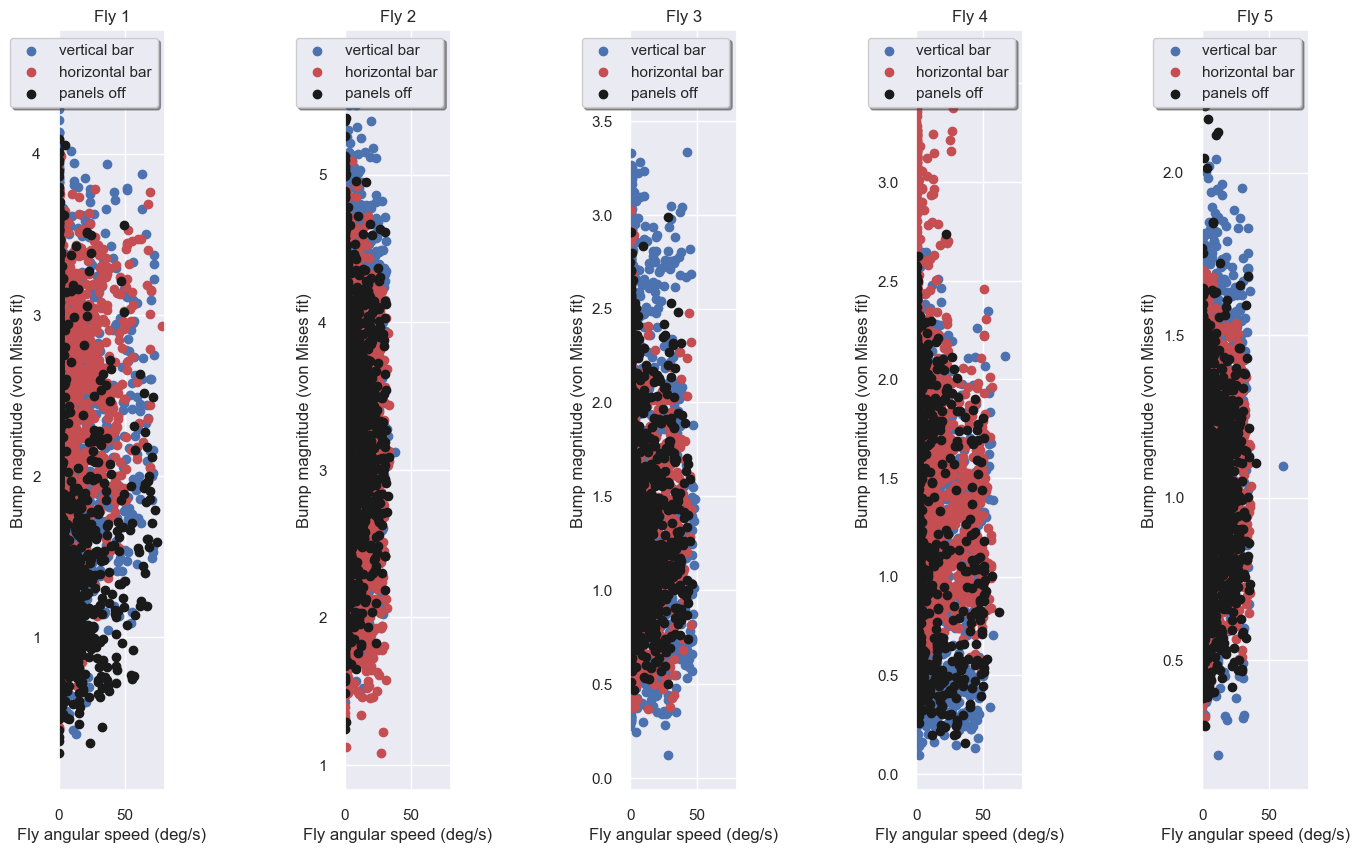

In [275]:
#Let's plot the changes in bump magnitude with respect to changes in angular speed and see if there is an apparent relationship

fig = plt.figure(figsize = (15, 10), dpi=100)
for fly in range(flyNum):
    ax = fig.add_subplot(1, 5, fly+1)
    ax.scatter(angSpeed[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 1)],bumpMagFit[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 1)] ,c='b')
    ax.scatter(angSpeed[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 2)],bumpMagFit[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 2)] ,c='r')
    ax.scatter(angSpeed[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 3)],bumpMagFit[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 3)] ,c='k')  
    plt.xlabel('Fly angular speed (deg/s)')
    plt.ylabel('Bump magnitude (von Mises fit)')
    plt.title('Fly ' + str(fly+1))
    ax.legend(('vertical bar','horizontal bar', 'panels off'), loc='upper right', frameon='True', shadow = 'True')
    ax.set_xlim([0,80])

    fig.tight_layout(pad=5.0)
    
plt.savefig(mainDir + "\plots\BumpMagVsAngSpeed3pattern.png", dpi=150)

In [276]:
#binned

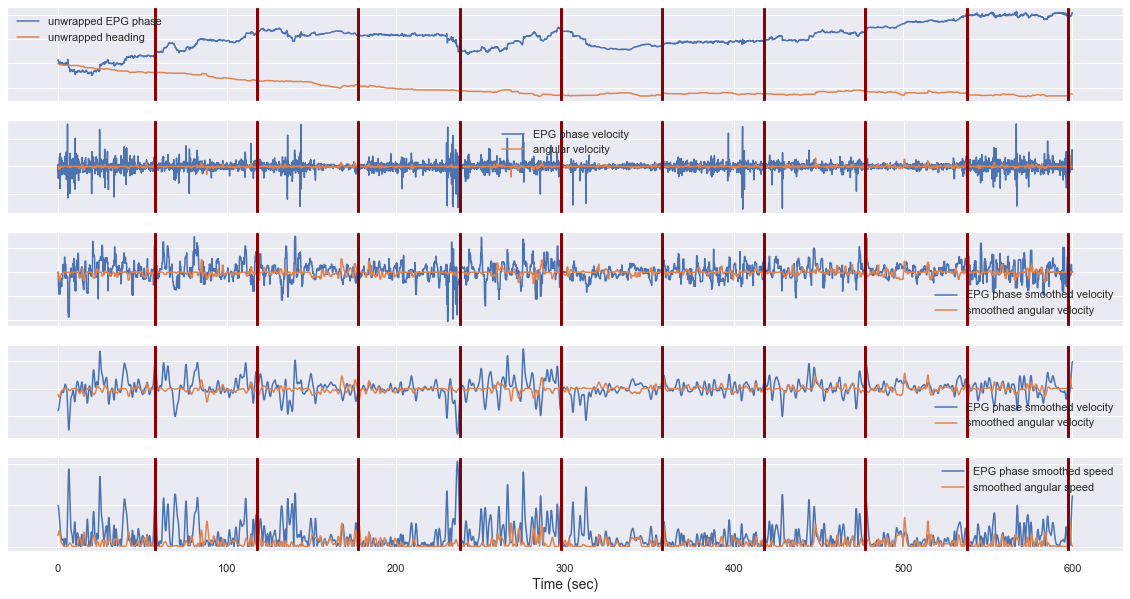

In [285]:
# Let's now analyze bump angular speed per state

totalTime = np.linspace(0, 600, frames)

#initialize arrays
unwrappedPhase = np.zeros((flyNum,frames))
diffUnwrapped = np.zeros((flyNum,frames))
smoothedDiff = np.zeros((flyNum,frames))
smoothedDiff2 = np.zeros((flyNum,frames))

# Get the bump's angular speed
for fly in range(flyNum):
    unwrappedPhase[fly] = np.unwrap(np.squeeze((flyGroupData[0,fly]['phase_value'])))
    diffUnwrapped[fly] = np.append(0,np.ediff1d(unwrappedPhase[fly])*frames/600) #get phase velocity
    smoothedDiff[fly] = medfilt(diffUnwrapped[fly], 11)  #smooth
    smoothedDiff2[fly] = gaussian_filter(diffUnwrapped[fly], sigma=5) #does this sigma represent frames? How do I choose the appropriate one?
#I don't think this is a great smoothing, I need to check.

# Let's do the same for the fly angular speed and compare
unwrappedHeading = np.zeros((flyNum,frames))
diffUnwrappedHeading = np.zeros((flyNum,frames))
smoothedDiffHeading = np.zeros((flyNum,frames))
smoothedDiff2Heading = np.zeros((flyNum,frames))

# Get the bump's angular speed
for fly in range(flyNum):
    unwrappedHeading[fly] = np.unwrap(np.squeeze((-flyGroupData[0,fly]['flyPosRad'])))
    diffUnwrappedHeading[fly] = np.append(0,np.ediff1d(unwrappedHeading[fly])*frames/600) #get phase velocity
    smoothedDiffHeading[fly] = medfilt(diffUnwrappedHeading[fly], 11)  #smooth
    smoothedDiff2Heading[fly] = gaussian_filter(diffUnwrappedHeading[fly], sigma=5) #does this sigma represent frames? How do I choose the appropriate one?
#I don't think this is a great smoothing, I need to check.



fig,
ax1 = plt.subplot(511)
ax1.plot(totalTime,unwrappedPhase[1])
ax1.plot(totalTime,unwrappedHeading[1])
ax1.legend(['unwrapped EPG phase','unwrapped heading'])
ax1.set_xticklabels([])
ax1.set_yticklabels([])
for change in range(len(changeStim)):
    plt.axvline(x=changeStim[change]*600/frames, linewidth=3, color='darkred')

ax2 = plt.subplot(512)
#ax2.plot(totalTime,diffUnwrapped[1])
ax2.plot(totalTime[:-1],np.ediff1d(unwrappedPhase[1]))
#ax2.plot(totalTime,diffUnwrappedHeading[1])
ax2.plot(totalTime[:-1],np.ediff1d(unwrappedHeading[1]))
ax2.legend(['EPG phase velocity','angular velocity'])
ax2.set_xticklabels([])
ax2.set_yticklabels([])
for change in range(len(changeStim)):
    plt.axvline(x=changeStim[change]*600/frames, linewidth=3, color='darkred')

ax3 = plt.subplot(513)
ax3.plot(totalTime,smoothedDiff[1])
ax3.plot(totalTime,smoothedDiffHeading[1])
ax3.legend(['EPG phase smoothed velocity','smoothed angular velocity'])
ax3.set_xticklabels([])
ax3.set_yticklabels([])
for change in range(len(changeStim)):
    plt.axvline(x=changeStim[change]*600/frames, linewidth=3, color='darkred')

ax4 = plt.subplot(514)
ax4.plot(totalTime,smoothedDiff2[1])
ax4.plot(totalTime,smoothedDiff2Heading[1])
ax4.legend(['EPG phase smoothed velocity','smoothed angular velocity'])
ax4.set_xticklabels([])
ax4.set_yticklabels([])
for change in range(len(changeStim)):
    plt.axvline(x=changeStim[change]*600/frames, linewidth=3, color='darkred')

ax5 = plt.subplot(515)
ax5.plot(totalTime,abs(smoothedDiff2[1]))
ax5.plot(totalTime,abs(smoothedDiff2Heading[1]))
ax5.legend(['EPG phase smoothed speed','smoothed angular speed'])
ax5.set_xlabel('Time (sec)',fontsize=14)
ax5.set_yticklabels([])
for change in range(len(changeStim)):
    plt.axvline(x=changeStim[change]*600/frames, linewidth=3, color='darkred')

plt.gcf().set_size_inches(20, 10)

#plt.savefig(mainDir + "\plots\BumpSpeedFlySpeed.png", dpi=150)


# Add to data frame
bumpAngSpeed = abs(np.rad2deg(np.reshape(smoothedDiff2,flyNum*frames)))
bumpDF['bumpAngSpeed'] = bumpAngSpeed

flyAngSpeed2 = abs(np.rad2deg(np.reshape(smoothedDiff2Heading,flyNum*frames)))
bumpDF['flyAngSpeed2'] = flyAngSpeed2

0.180868409435884

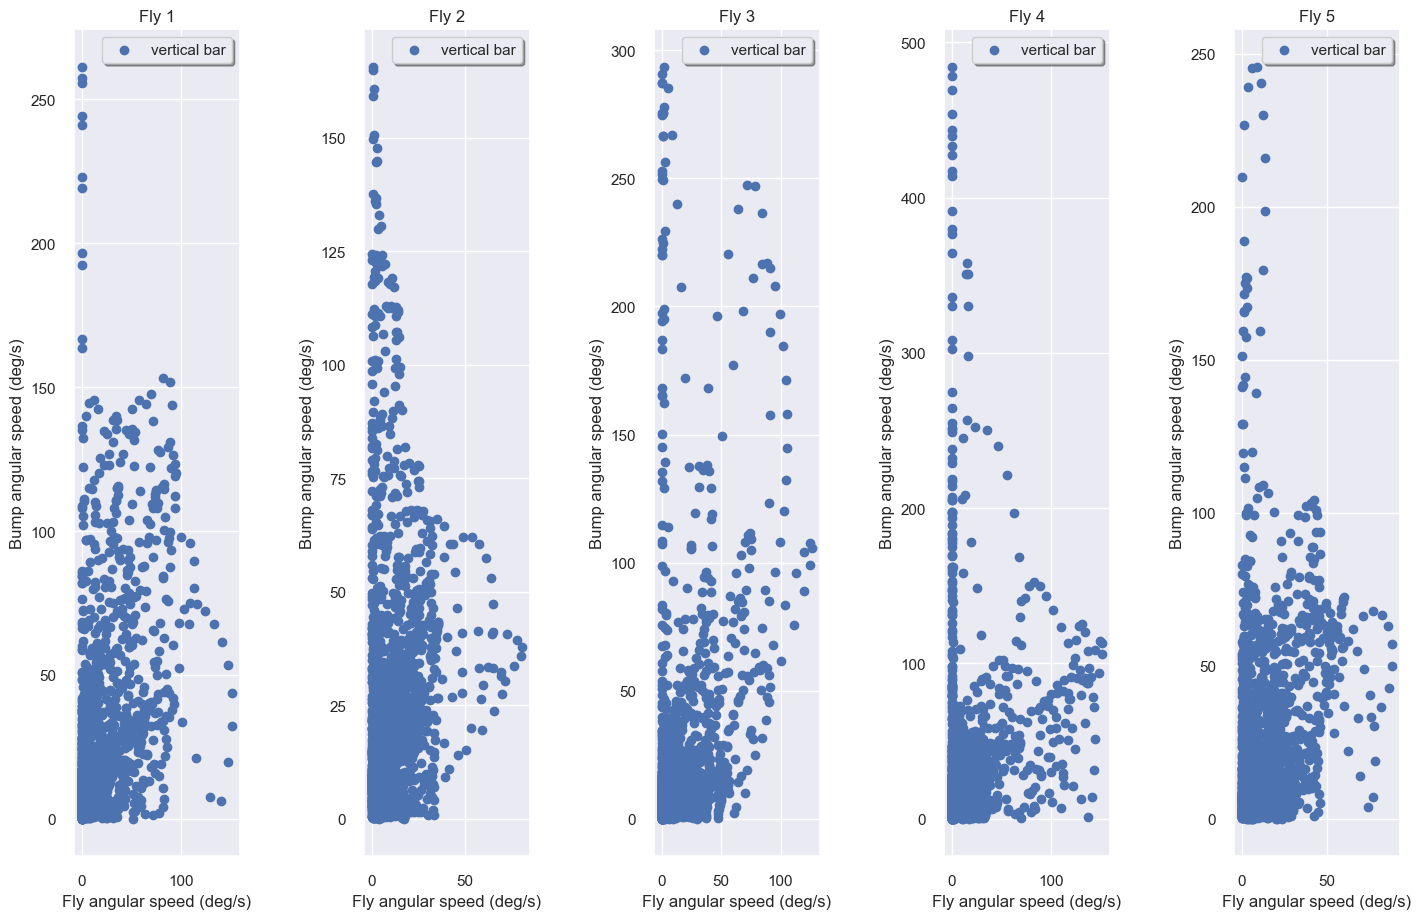

In [288]:
#Plot bump angular speed vs fly angular speed

fig = plt.figure(figsize = (15, 10), dpi=100)

for fly in range(flyNum):
    ax = fig.add_subplot(1, flyNum, fly+1)
    ax.scatter(flyAngSpeed2[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 1)],bumpAngSpeed[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 1)] ,c='b')
    #ax.scatter(flyAngSpeed2[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 2)],bumpAngSpeed[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 2)] ,c='r')
    #ax.scatter(flyAngSpeed2[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 3)],bumpAngSpeed[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 3)] ,c='k')  
    plt.xlabel('Fly angular speed (deg/s)')
    plt.ylabel('Bump angular speed (deg/s)')
    plt.title('Fly ' + str(fly+1))
    #plt.xlim([0,30])
    #plt.ylim([0,50])
    ax.legend(('vertical bar','horizontal bar', 'panels off'), loc='upper right', frameon='True', shadow = 'True')
    fig.tight_layout(pad=3.0)
    
#plt.savefig(mainDir + "\plots\BumpSpeedVsFlySpeed.png", dpi=150)

#It is pretty weird that theer seems to be little correlation between the angular speeds for vertical bar, even though the correlations by lag we did before showed correlation...
pearsonr(flyAngSpeed2[(bumpDF['Fly ID'] == 4) & (bumpDF['State'] == 1)],bumpAngSpeed[(bumpDF['Fly ID'] == 4) & (bumpDF['State'] == 1)])[0]

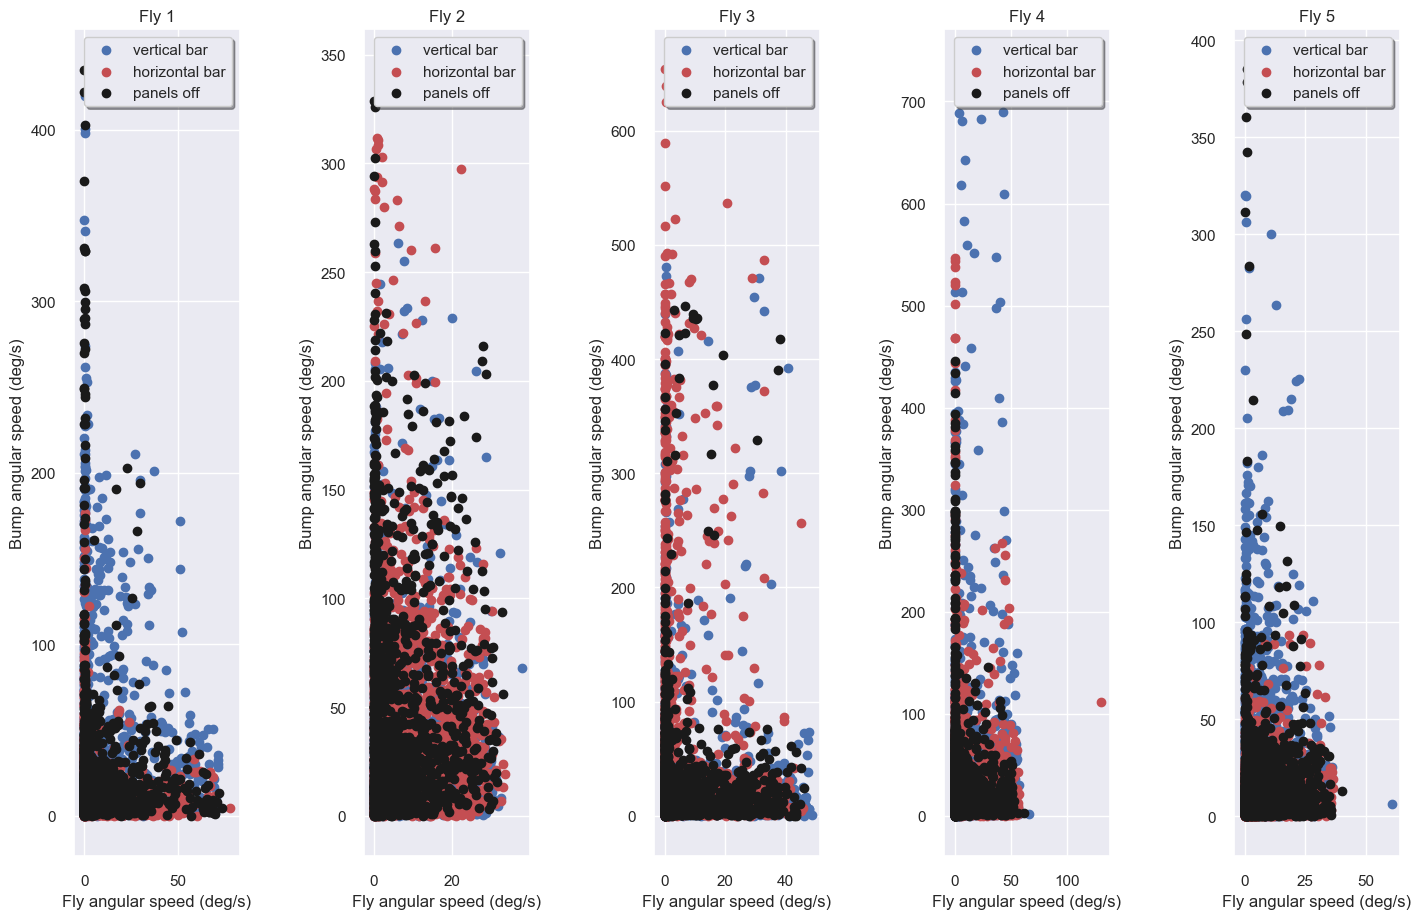

In [280]:
#Let's look at the correlation with the already saved ang speed from the matlab data

fig = plt.figure(figsize = (15, 10), dpi=100)

for fly in range(flyNum):
    ax = fig.add_subplot(1, flyNum, fly+1)
    ax.scatter(angSpeed[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 1)],bumpAngSpeed[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 1)] ,c='b')
    ax.scatter(angSpeed[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 2)],bumpAngSpeed[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 2)] ,c='r')
    ax.scatter(angSpeed[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 3)],bumpAngSpeed[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 3)] ,c='k')  
    plt.xlabel('Fly angular speed (deg/s)')
    plt.ylabel('Bump angular speed (deg/s)')
    plt.title('Fly ' + str(fly+1))
    #plt.xlim([0,30])
    #plt.ylim([0,50])
    ax.legend(('vertical bar','horizontal bar', 'panels off'), loc='upper right', frameon='True', shadow = 'True')
    fig.tight_layout(pad=3.0)
    
#This doesn't look better...

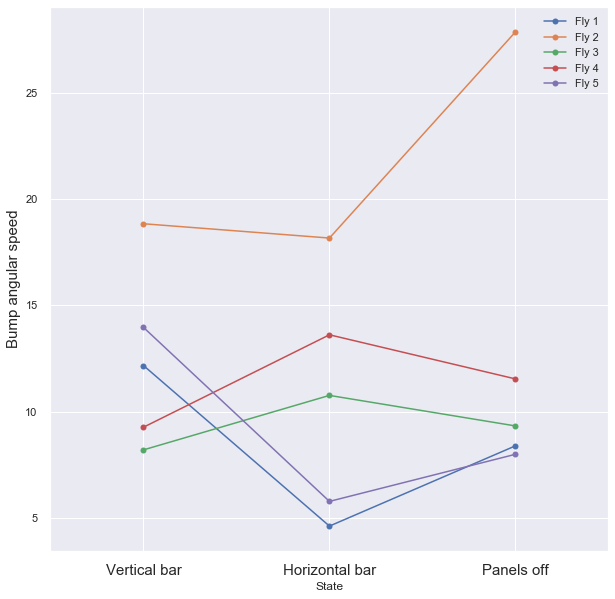

In [289]:
# Let's look at the relationship between bump speed and state

bumpDF.groupby(['State','Fly ID'])[['bumpAngSpeed']].median().unstack().plot(marker="o")
plt.ylabel('Bump angular speed', fontsize=15)
plt.xticks([1,2,3], ['Vertical bar','Horizontal bar','Panels off'],fontsize=15)
plt.legend(['Fly 1', 'Fly 2', 'Fly 3', 'Fly 4', 'Fly 5'])
plt.xlim(0.5,3.5)
plt.gcf().set_size_inches(10, 10)
plt.savefig(mainDir + "\plots\BumpSpeedWithState3pattern.png", dpi=150)

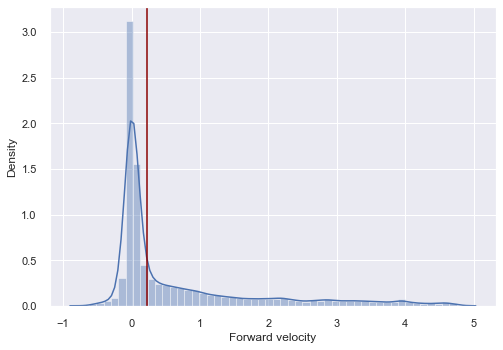

In [271]:
# Diving the data in standing and walking bouts

# Get all the forward velocities and plot histogram
allWalkingVelocities = np.concatenate((flyGroupData[0,0]['for_vel'],flyGroupData[0,1]['for_vel'],flyGroupData[0,2]['for_vel']))
allWalkingVelocities = np.concatenate((allWalkingVelocities,flyGroupData[0,3]['for_vel'],flyGroupData[0,4]['for_vel']))
allWalkingVelocities = np.reshape(allWalkingVelocities,flyNum*frames)
densityVal = np.asarray(sns.distplot(allWalkingVelocities).get_lines()[0].get_data())
plt.xlabel('Forward velocity')
plt.ylabel('Density')


# Determine the threshold between standing and moving as the valley between the two peaks in the distribution
I = np.argmax(densityVal[1,:],axis=0)
I2 = np.argmin(abs(densityVal[1,I:]-(densityVal[1,I]/2)),axis=0)+1
thresholdVel = densityVal[0,I+I2+1]

plt.axvline(x=thresholdVel,color='darkred')
#plt.savefig(mainDir + "\plots\VelThreshold.png", dpi=150)

C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


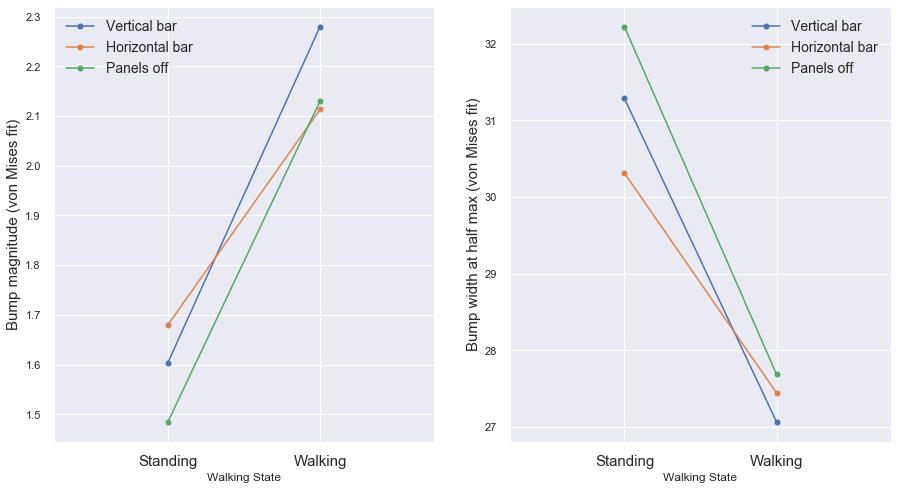

In [273]:
# Get and plot bump magnitude and width at half max in walking and standing bouts for every state

#Find data points above the velocity threshold
walkingBouts = allWalkingVelocities>thresholdVel
bumpDF['Walking State'] = walkingBouts

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

bumpDF.groupby(['Walking State','State'])[['bumpMagFit']].mean().unstack().plot(marker='o',ax=ax1)
ax1.set_ylabel('Bump magnitude (von Mises fit)', fontsize=15)
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['Standing','Walking'],fontsize=15)
ax1.legend(['Vertical bar','Horizontal bar','Panels off'],fontsize=14,loc=2)
ax1.set_xlim(-0.75,1.75)

bumpDF.groupby(['Walking State','State'])[['bumpHWFit']].mean().unstack().plot(marker='o',ax=ax2)
ax2.set_ylabel('Bump width at half max (von Mises fit)', fontsize=15)
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['Standing','Walking'],fontsize=15)
ax2.legend(['Vertical bar','Horizontal bar','Panels off'],fontsize=14)
ax2.set_xlim(-0.75,1.75)

plt.gcf().set_size_inches(15, 8)


plt.savefig(mainDir + "\plots\BumpWithWalkingState3pattern.png", dpi=150)